산업통상자원부 공모전(빅데이터 분석 과제4): https://datacontest.kr/apply/applyAdd/3  
기상청 종관기상관측(ASOS)자료: https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36  
한국전력거래소_5분단위 전력수급현황: https://www.data.go.kr/data/15099819/fileData.do

# 기상정보를 활용한 실시간 전력수요 예측모델 개발

##### ※ 본 프로젝트는 산업통상자원부에서 주최하는 2023년 제 11회 공공데이터 활용BI 공모전 빅데이터 분석 부문에 참여하면서 진행하였습니다.

- 프로젝트 주제: 기상정보를 활용한 실시간 전력수요 예측모델 개발  
- 분석 대상 기간: 23.3.13(월) ~ 23.3.19(일)(1주일)  
- 유의사항:
  1. 향후 6시간까지의 5분 단위 예측 모델 제시  
  2. MAPE(Mean Absolute Percentage Error)로 제시 

# EDA

## 1. 데이터 불러오기 & 결합

* 전력수요량 추출을 위한 전력수급데이터와 기상변수량 추출을 위한 기상데이터 불러오기.  
* 먼저 데이터 제공기간이 더 짧은 전력데이터 탐색.  
* 일시 기준으로 전력수급데이터가 2012.06.01 ~ 2022.04.07과 2022.04.01 ~ 2023.04.30로 나눠져 있음.  
* 둘다 불러온다.

In [127]:
df_ps = pd.read_csv("한국전력거래소_5분단위 전력수급현황(20120601~20220407).csv",encoding='cp949')
df_ps

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
0,2012-06-01 00:00,64355.0,51726.33,59400,12628.67,24.41439,12628.67,24.41439
1,2012-06-01 00:05,64355.0,51342.53,60800,13012.47,25.34442,13012.47,25.34442
2,2012-06-01 00:10,64355.0,51583.17,60800,12771.83,24.75969,12771.83,24.75969
3,2012-06-01 00:15,64355.0,51631.69,60800,12723.31,24.64245,12723.31,24.64245
4,2012-06-01 00:20,64355.0,51252.66,60800,13102.35,25.56423,13102.35,25.56423
...,...,...,...,...,...,...,...,...
1035062,2022-04-07 23:35,82791.9,63877.30,69300,18914.70,29.61100,10803.00,16.91210
1035063,2022-04-07 23:40,82768.1,63525.30,69300,19242.80,30.29160,10696.40,16.83800
1035064,2022-04-07 23:45,82767.9,63506.20,69300,19261.70,30.33040,10501.30,16.53580
1035065,2022-04-07 23:50,82762.4,62819.60,69300,19942.80,31.74610,10706.30,17.04290


In [128]:
df_ps2 = pd.read_csv("한국전력거래소_5분단위 전력수급현황(20220401~20230430).csv",encoding='cp949')
df_ps2

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
0,2022-04-01 00:00,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
1,2022-04-01 00:05,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2,2022-04-01 00:10,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
3,2022-04-01 00:15,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
4,2022-04-01 00:20,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...,...
113638,2023-04-30 23:35,76101.03,53828.62,57300,22272.40,41.37651,9389.09,17.44257
113639,2023-04-30 23:40,76084.24,53693.20,57300,22391.04,41.70181,8897.85,16.57166
113640,2023-04-30 23:45,76083.32,52937.98,57300,23145.34,43.72161,9257.95,17.48829
113641,2023-04-30 23:50,76077.47,52679.85,57300,23397.62,44.41474,9303.84,17.66110


* 기간이 겹치는 2022-04-01 ~ 2022-04-07 데이터를 각각 불러와서 비교   


In [129]:
# df_ps(2022-04-01 ~ 2022-04-07 23:55:00)
# 기준일시를 날짜형식으로 변환
df_ps['기준일시'] = pd.to_datetime(df_ps['기준일시'])

# 2022-04-01부터 2022-04-07 23:55:00까지의 값을 찾기
start_date = pd.to_datetime('2022-04-01')
end_date = pd.to_datetime('2022-04-07 23:55:00')
df_ps_filtered = df_ps[(df_ps['기준일시'] >= start_date) & (df_ps['기준일시'] <= end_date)]
df_ps_filtered

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
1033176,2022-04-01 00:00:00,82494.3,62453.3,70100,20041.0,32.0895,9257.46,14.8230
1033177,2022-04-01 00:05:00,83807.2,62329.3,70700,21478.0,34.4589,10889.30,17.4706
1033178,2022-04-01 00:10:00,83799.1,61831.0,70700,21968.2,35.5294,10865.90,17.5735
1033179,2022-04-01 00:15:00,83790.4,61648.7,70700,22141.7,35.9159,10864.30,17.6228
1033180,2022-04-01 00:20:00,83770.8,61382.6,70700,22388.2,36.4732,10452.00,17.0275
...,...,...,...,...,...,...,...,...
1035062,2022-04-07 23:35:00,82791.9,63877.3,69300,18914.7,29.6110,10803.00,16.9121
1035063,2022-04-07 23:40:00,82768.1,63525.3,69300,19242.8,30.2916,10696.40,16.8380
1035064,2022-04-07 23:45:00,82767.9,63506.2,69300,19261.7,30.3304,10501.30,16.5358
1035065,2022-04-07 23:50:00,82762.4,62819.6,69300,19942.8,31.7461,10706.30,17.0429


In [130]:
# df_ps2(2022-04-01 ~ 2022-04-07 23:55:00)
# 기준일시를 날짜형식으로 변환
df_ps2['기준일시'] = pd.to_datetime(df_ps2['기준일시'])

# 2022-04-01부터 2022-04-07 23:55:00까지의 값을 찾기
start_date = pd.to_datetime('2022-04-01')
end_date = pd.to_datetime('2022-04-07 23:55:00')
df_ps_filtered2 = df_ps2[(df_ps2['기준일시'] >= start_date) & (df_ps2['기준일시'] <= end_date)]
df_ps_filtered2

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
0,2022-04-01 00:00:00,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
1,2022-04-01 00:05:00,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2,2022-04-01 00:10:00,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
3,2022-04-01 00:15:00,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
4,2022-04-01 00:20:00,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...,...
2009,2022-04-07 23:35:00,82791.92,63877.26,69300,18914.66,29.61095,10802.99,16.91210
2010,2022-04-07 23:40:00,82768.10,63525.30,69300,19242.80,30.29156,10696.36,16.83795
2011,2022-04-07 23:45:00,82767.92,63506.23,69300,19261.68,30.33039,10501.27,16.53581
2012,2022-04-07 23:50:00,82762.37,62819.60,69300,19942.77,31.74610,10706.29,17.04291


In [131]:
# 공통 기준일시 값 추출
common_dates = set(df_ps_filtered['기준일시']).intersection(df_ps_filtered2['기준일시'])

# 첫 번째 데이터프레임에 있는 값과 없는 값 비교
in_df1 = df_ps_filtered['기준일시'].isin(common_dates)
not_in_df1 = ~in_df1

# 두 번째 데이터프레임에 있는 값과 없는 값 비교
in_df2 = df_ps_filtered2['기준일시'].isin(common_dates)
not_in_df2 = ~in_df2

# 결과 출력
print("첫 번째 데이터프레임에 없는 값:")
print(df_ps_filtered[not_in_df1])

print("두 번째 데이터프레임에 없는 값:")
print(df_ps_filtered2[not_in_df2])

첫 번째 데이터프레임에 없는 값:
Empty DataFrame
Columns: [기준일시, 공급능력(MW), 현재수요(MW), 최대예측수요(MW), 공급예비력(MW), 공급예비율(퍼센트), 운영예비력(MW), 운영예비율(퍼센트)]
Index: []
두 번째 데이터프레임에 없는 값:
                    기준일시  공급능력(MW)  현재수요(MW)  최대예측수요(MW)  공급예비력(MW)  \
1603 2022-04-06 13:45:00  84993.32  59939.30       70000   25054.01   
1604 2022-04-06 13:50:00  84990.17  60169.38       70000   24820.79   
1605 2022-04-06 13:55:00  84984.66  60086.69       70000   24897.97   
1606 2022-04-06 14:00:00  85038.34  60246.37       70000   24791.96   
1607 2022-04-06 14:05:00  84799.90  59972.00       70000   24827.90   
...                  ...       ...       ...         ...        ...   
1721 2022-04-06 23:35:00  83374.82  63386.87       70000   19987.95   
1722 2022-04-06 23:40:00  83378.75  63392.59       70000   19986.15   
1723 2022-04-06 23:45:00  83377.88  63102.06       70000   20275.81   
1724 2022-04-06 23:50:00  83372.41  62452.65       70000   20919.76   
1725 2022-04-06 23:55:00  83370.93  61857.57       70000   21

* 첫번째 데이터프레임에는 결측값이 없고 두번째 데이터프레임에는 있는것을 확인.
* 그러면 겹치는 일시의 데이터들이 같은 값을 갖고있는지 비교.
* 소수점 단위로 차이가 있지만 크게 다르지 않는것으로 보임. 
* 필요한 데이터인 현재수요(MW)량을 기준으로 차이가 1이 넘는 경우만 수정하겠음.  

In [132]:
# '기준일시'를 기준으로 두 데이터프레임 조인
merged = pd.merge(df_ps_filtered, df_ps_filtered2, on='기준일시', suffixes=('_df1', '_df2'))

# 현재수요값의 차이 계산
merged['차이'] = merged['현재수요(MW)_df2'] - merged['현재수요(MW)_df1']

# 차이의 절대값이 1 이상인 행 추출
difference_over_1 = merged[abs(merged['차이']) >= 1]

# 결과 출력
print("차이의 절대값이 1 이상인 행들:")
print(difference_over_1)

차이의 절대값이 1 이상인 행들:
Empty DataFrame
Columns: [기준일시, 공급능력(MW)_df1, 현재수요(MW)_df1, 최대예측수요(MW)_df1, 공급예비력(MW)_df1, 공급예비율(퍼센트)_df1, 운영예비력(MW)_df1, 운영예비율(퍼센트)_df1, 공급능력(MW)_df2, 현재수요(MW)_df2, 최대예측수요(MW)_df2, 공급예비력(MW)_df2, 공급예비율(퍼센트)_df2, 운영예비력(MW)_df2, 운영예비율(퍼센트)_df2, 차이]
Index: []


* 확인결과 차이가 1을 넘는 경우는 없음. 소수점 단위, 반올림 등으로 인한 작은 차이
* 2022-04-01 ~ 2022-04-07 데이터는 결측값이 없는 첫번째 데이터프레임으로 사용결정
* 프로젝트에 필요한 현재수요 칼럼을 기준으로 두 데이터 outer 조인으로 합치기

In [133]:
# 기준일시, 현재수요 칼럼만 추출
df_cd = pd.DataFrame(df_ps[['기준일시','현재수요(MW)']])
df_cd2 = pd.DataFrame(df_ps2[['기준일시','현재수요(MW)']])

# 첫번째 데이터프레임을 기준으로 두 데이터프레임 합치기
merged = pd.merge(df_ps_cd, df_ps_cd2, on='기준일시', how='outer', suffixes=('_df1', '_df2'))

# 같은 값이 있는 경우 첫번째 데이터프레임의 값으로 채우기
merged['현재수요(MW)'] = merged['현재수요(MW)_df1'].combine_first(merged['현재수요(MW)_df2'])

# 기준일시 열과 불필요한 열 제거
merged.drop(['현재수요(MW)_df1', '현재수요(MW)_df2'], axis=1, inplace=True)

# 결과 출력
df_cd_merge = pd.DataFrame(merged)
df_cd_merge

,기준일시,현재수요(MW)
0,2012-06-01 00:00:00,51726.33
1,2012-06-01 00:05:00,51342.53
2,2012-06-01 00:10:00,51583.17
3,2012-06-01 00:15:00,51631.69
4,2012-06-01 00:20:00,51252.66
...,...,...
1146814,2023-04-30 23:35:00,53828.62
1146815,2023-04-30 23:40:00,53693.20
1146816,2023-04-30 23:45:00,52937.98
1146817,2023-04-30 23:50:00,52679.85


## 데이터 시각화

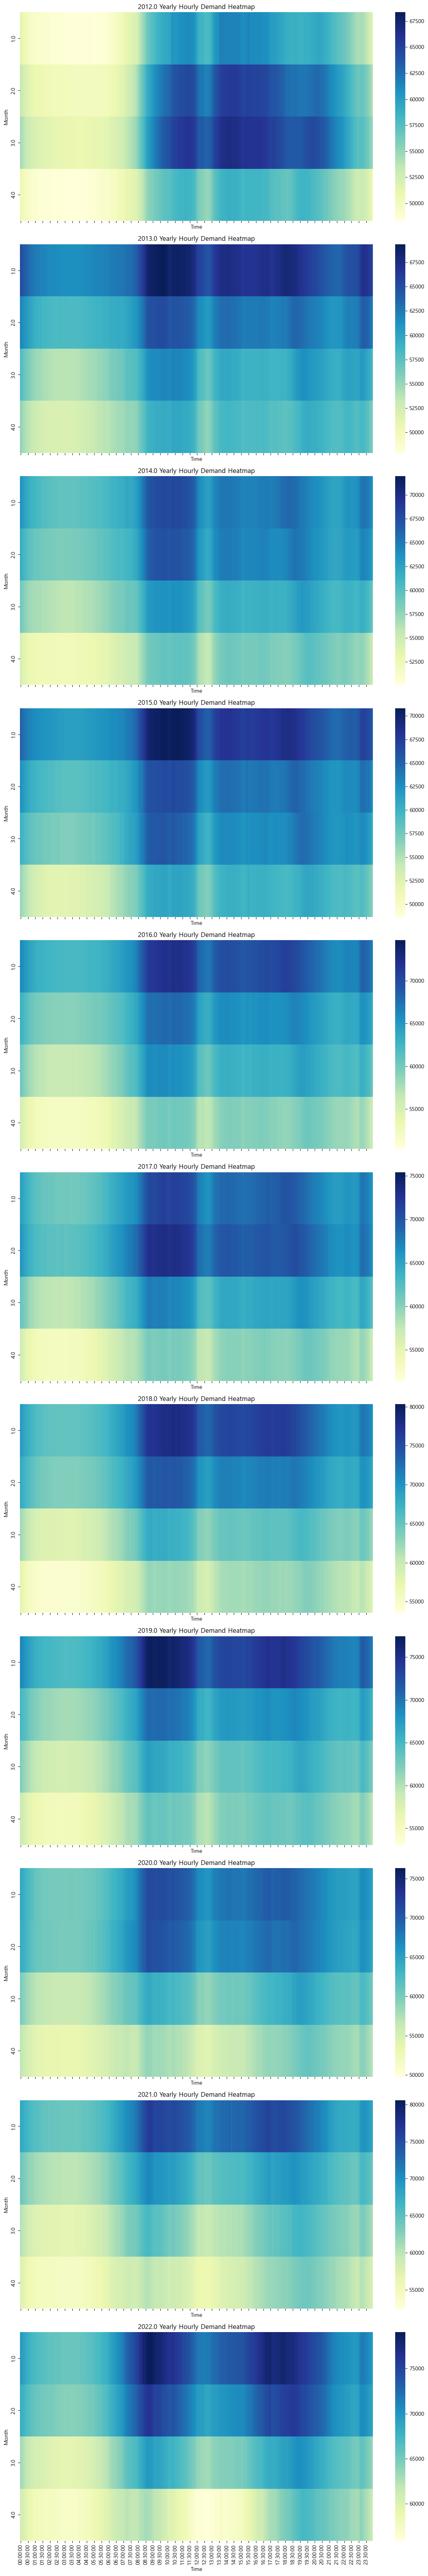

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# '기준일시' 열을 datetime 형식으로 변환
df_cd_merge['기준일시'] = pd.to_datetime(df['기준일시'])

# '년도', '월', '시간' 열 추가
df_cd_merge['년도'] = df_cd_merge['기준일시'].dt.year
df_cd_merge['월'] = df_cd_merge['기준일시'].dt.month
df_cd_merge['시간'] = df_cd_merge['기준일시'].dt.time

# 년도별로 데이터프레임 분할
df_yearly = df_cd_merge.groupby('년도')

# 히트맵 그리기
fig, axes = plt.subplots(len(df_yearly), figsize=(12, 6*len(df_yearly)), sharex=True, sharey=True)

for i, (year, group) in enumerate(df_yearly):
    # 월별 시간별 전력수요 피벗 테이블 생성
    pivot_table = group.pivot_table(index='월', columns='시간', values='현재수요(MW)')

    # 히트맵 그리기
    sns.heatmap(pivot_table, cmap='YlGnBu', ax=axes[i])
    axes[i].set_title(f'{year} Yearly Hourly Demand Heatmap')
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Month')

plt.tight_layout()
plt.show()



In [74]:
pd.DataFrame(filtered_df[in_df1])

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
1033176,2022-04-01 00:00:00,82494.3,62453.3,70100,20041.0,32.0895,9257.46,14.8230
1033177,2022-04-01 00:05:00,83807.2,62329.3,70700,21478.0,34.4589,10889.30,17.4706
1033178,2022-04-01 00:10:00,83799.1,61831.0,70700,21968.2,35.5294,10865.90,17.5735
1033179,2022-04-01 00:15:00,83790.4,61648.7,70700,22141.7,35.9159,10864.30,17.6228
1033180,2022-04-01 00:20:00,83770.8,61382.6,70700,22388.2,36.4732,10452.00,17.0275
...,...,...,...,...,...,...,...,...
1035062,2022-04-07 23:35:00,82791.9,63877.3,69300,18914.7,29.6110,10803.00,16.9121
1035063,2022-04-07 23:40:00,82768.1,63525.3,69300,19242.8,30.2916,10696.40,16.8380
1035064,2022-04-07 23:45:00,82767.9,63506.2,69300,19261.7,30.3304,10501.30,16.5358
1035065,2022-04-07 23:50:00,82762.4,62819.6,69300,19942.8,31.7461,10706.30,17.0429


In [56]:
df_ps_merged = pd.merge(df_ps, df_ps2, on='기준일시')
df_ps_merged

,기준일시,공급능력(MW)_x,현재수요(MW)_x,최대예측수요(MW)_x,공급예비력(MW)_x,공급예비율(퍼센트)_x,운영예비력(MW)_x,운영예비율(퍼센트)_x,공급능력(MW)_y,현재수요(MW)_y,최대예측수요(MW)_y,공급예비력(MW)_y,공급예비율(퍼센트)_y,운영예비력(MW)_y,운영예비율(퍼센트)_y
0,2022-04-01 00:00,82494.3,62453.3,70100,20041.0,32.0895,9257.46,14.8230,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
1,2022-04-01 00:05,83807.2,62329.3,70700,21478.0,34.4589,10889.30,17.4706,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2,2022-04-01 00:10,83799.1,61831.0,70700,21968.2,35.5294,10865.90,17.5735,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
3,2022-04-01 00:15,83790.4,61648.7,70700,22141.7,35.9159,10864.30,17.6228,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
4,2022-04-01 00:20,83770.8,61382.6,70700,22388.2,36.4732,10452.00,17.0275,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886,2022-04-07 23:35,82791.9,63877.3,69300,18914.7,29.6110,10803.00,16.9121,82791.92,63877.26,69300,18914.66,29.61095,10802.99,16.91210
1887,2022-04-07 23:40,82768.1,63525.3,69300,19242.8,30.2916,10696.40,16.8380,82768.10,63525.30,69300,19242.80,30.29156,10696.36,16.83795
1888,2022-04-07 23:45,82767.9,63506.2,69300,19261.7,30.3304,10501.30,16.5358,82767.92,63506.23,69300,19261.68,30.33039,10501.27,16.53581
1889,2022-04-07 23:50,82762.4,62819.6,69300,19942.8,31.7461,10706.30,17.0429,82762.37,62819.60,69300,19942.77,31.74610,10706.29,17.04291


In [ ]:
기준일시가 겹치는 부분이 있음.결합. 

In [41]:
import pandas as pd

# 기상정보
df_weather = pd.read_csv("기상정보.csv")
df_weather = df_weather.drop('Unnamed: 0',axis=1)
df_weather

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),...,현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),일사 QC플래그,적설(cm),지면온도(°C),지면온도 QC플래그
0,90,속초,2022-04-01 00:00,3.8,NaN,NaN,9.0,1.3,NaN,270.0,...,NaN,1029.5,NaN,NaN,9.0,NaN,9.0,NaN,3.9,NaN
1,90,속초,2022-04-01 01:00,3.4,NaN,NaN,NaN,1.4,NaN,290.0,...,NaN,1029.9,NaN,NaN,9.0,NaN,9.0,NaN,3.1,NaN
2,90,속초,2022-04-01 02:00,2.8,NaN,NaN,NaN,1.7,NaN,290.0,...,NaN,1029.9,NaN,NaN,9.0,NaN,9.0,NaN,2.6,NaN
3,90,속초,2022-04-01 03:00,2.4,NaN,NaN,NaN,1.9,NaN,290.0,...,NaN,1029.9,NaN,NaN,9.0,NaN,9.0,NaN,2.3,NaN
4,90,속초,2022-04-01 04:00,2.9,NaN,NaN,NaN,1.1,NaN,320.0,...,NaN,1030.3,NaN,NaN,9.0,NaN,9.0,NaN,2.3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830010,295,남해,2023-03-30 20:00,14.2,NaN,NaN,NaN,0.3,NaN,0.0,...,NaN,1018.0,NaN,NaN,9.0,NaN,9.0,NaN,12.6,NaN
830011,295,남해,2023-03-30 21:00,13.9,NaN,NaN,NaN,0.3,NaN,0.0,...,NaN,1018.4,NaN,NaN,9.0,NaN,9.0,NaN,11.8,NaN
830012,295,남해,2023-03-30 22:00,13.3,NaN,NaN,NaN,0.4,NaN,0.0,...,NaN,1018.4,NaN,NaN,9.0,NaN,9.0,NaN,10.8,NaN
830013,295,남해,2023-03-30 23:00,13.0,NaN,NaN,NaN,0.7,NaN,250.0,...,NaN,1018.6,NaN,NaN,9.0,NaN,9.0,NaN,10.8,NaN


In [44]:
df_weather2 = pd.read_csv("기상정보2.csv",encoding ='cp949')
df_weather2 

,지점,지점명,일시,기온(°C),기온 QC플래그,강수량(mm),강수량 QC플래그,풍속(m/s),풍속 QC플래그,풍향(16방위),...,현지기압 QC플래그,해면기압(hPa),해면기압 QC플래그,일조(hr),일조 QC플래그,일사(MJ/m2),일사 QC플래그,적설(cm),지면온도(°C),지면온도 QC플래그
0,90,속초,2023-03-31 01:00,16.9,NaN,NaN,NaN,0.6,NaN,200.0,...,NaN,1016.5,NaN,NaN,9.0,NaN,9.0,NaN,8.9,NaN
1,90,속초,2023-03-31 02:00,16.9,NaN,NaN,NaN,1.3,NaN,360.0,...,NaN,1016.5,NaN,NaN,9.0,NaN,9.0,NaN,8.9,NaN
2,90,속초,2023-03-31 03:00,17.1,NaN,NaN,NaN,1.8,NaN,290.0,...,NaN,1016.2,NaN,NaN,9.0,NaN,9.0,NaN,8.5,NaN
3,90,속초,2023-03-31 04:00,16.2,NaN,NaN,NaN,1.7,NaN,270.0,...,NaN,1016.3,NaN,NaN,9.0,NaN,9.0,NaN,8.5,NaN
4,90,속초,2023-03-31 05:00,14.9,NaN,NaN,NaN,0.9,NaN,200.0,...,NaN,1016.6,NaN,NaN,9.0,NaN,9.0,NaN,7.4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70676,295,남해,2023-04-30 20:00,16.0,NaN,NaN,NaN,0.5,NaN,290.0,...,NaN,1011.8,NaN,0.0,NaN,NaN,9.0,NaN,13.7,NaN
70677,295,남해,2023-04-30 21:00,15.4,NaN,NaN,NaN,0.6,NaN,250.0,...,NaN,1012.8,NaN,NaN,9.0,NaN,9.0,NaN,12.5,NaN
70678,295,남해,2023-04-30 22:00,12.8,NaN,NaN,NaN,0.5,NaN,290.0,...,NaN,1013.2,NaN,NaN,9.0,NaN,9.0,NaN,11.3,NaN
70679,295,남해,2023-04-30 23:00,14.3,NaN,NaN,NaN,0.3,NaN,0.0,...,NaN,1013.1,NaN,NaN,9.0,NaN,9.0,NaN,10.8,NaN


In [18]:
import pandas as pd

# 기상정보
df_weather = pd.read_csv("기상정보.csv",encoding = 'cp949')
df_weather

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,90,속초,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,90,속초,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,90,속초,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,90,속초,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763881,295,남해,2023-04-29 20:00,15.0,NaN,2.9,290.0,74.0,1001.9,0.0,NaN,NaN,10.0,15.1
763882,295,남해,2023-04-29 21:00,13.7,NaN,3.4,290.0,71.0,1002.7,NaN,NaN,NaN,8.0,13.9
763883,295,남해,2023-04-29 22:00,12.6,NaN,3.5,290.0,70.0,1003.3,NaN,NaN,NaN,8.0,12.2
763884,295,남해,2023-04-29 23:00,11.8,NaN,1.4,250.0,71.0,1003.6,NaN,NaN,NaN,6.0,11.2


In [19]:
# 기상정보추가

df_weather2 = pd.read_csv("기상정보2.csv",encoding = 'cp949')
df_weather2

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-04-01 00:00,3.8,NaN,1.3,270.0,84.0,1027.3,NaN,NaN,NaN,5.0,3.9
1,90,속초,2022-04-01 01:00,3.4,NaN,1.4,290.0,88.0,1027.7,NaN,NaN,NaN,4.0,3.1
2,90,속초,2022-04-01 02:00,2.8,NaN,1.7,290.0,86.0,1027.7,NaN,NaN,NaN,1.0,2.6
3,90,속초,2022-04-01 03:00,2.4,NaN,1.9,290.0,87.0,1027.7,NaN,NaN,NaN,0.0,2.3
4,90,속초,2022-04-01 04:00,2.9,NaN,1.1,320.0,84.0,1028.1,NaN,NaN,NaN,6.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134512,295,남해,2022-05-29 19:00,22.0,NaN,1.1,200.0,39.0,999.6,0.0,NaN,NaN,7.0,27.8
134513,295,남해,2022-05-29 20:00,21.7,NaN,0.5,180.0,33.0,999.7,0.0,NaN,NaN,5.0,25.2
134514,295,남해,2022-05-29 21:00,21.4,NaN,0.9,110.0,45.0,999.9,NaN,NaN,NaN,0.0,24.3
134515,295,남해,2022-05-29 22:00,21.1,NaN,1.4,180.0,52.0,1000.0,NaN,NaN,NaN,2.0,23.8


In [20]:
df_weather3 = pd.read_csv("기상정보3.csv",encoding = 'cp949')
df_weather3

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2023-04-29 01:00,16.5,NaN,1.5,340,67,1008.2,NaN,NaN,NaN,10,15.3
1,90,속초,2023-04-29 02:00,16.9,NaN,0.9,320,65,1007.6,NaN,NaN,NaN,10,15.2
2,90,속초,2023-04-29 03:00,15.9,0.0,0.8,20,71,1007.0,NaN,NaN,NaN,10,15.1
3,90,속초,2023-04-29 04:00,14.4,0.3,2.0,360,82,1006.3,NaN,NaN,NaN,10,14.5
4,90,속초,2023-04-29 05:00,12.9,0.1,1.4,340,86,1006.2,NaN,NaN,NaN,10,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,295,남해,2023-04-30 20:00,16.0,NaN,0.5,290,47,1006.4,0.0,NaN,NaN,0,13.7
4557,295,남해,2023-04-30 21:00,15.4,NaN,0.6,250,47,1007.4,NaN,NaN,NaN,0,12.5
4558,295,남해,2023-04-30 22:00,12.8,NaN,0.5,290,61,1007.7,NaN,NaN,NaN,0,11.3
4559,295,남해,2023-04-30 23:00,14.3,NaN,0.3,0,50,1007.7,NaN,NaN,NaN,0,10.8


In [21]:
# 기상정보 병합
df_weather_merge = pd.concat([weather_variable,weather_variable2,weather_variable3])
df_weather_merge 

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,90,속초,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,90,속초,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,90,속초,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,90,속초,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,295,남해,2023-04-30 20:00,16.0,NaN,0.5,290.0,47.0,1006.4,0.0,NaN,NaN,0.0,13.7
4557,295,남해,2023-04-30 21:00,15.4,NaN,0.6,250.0,47.0,1007.4,NaN,NaN,NaN,0.0,12.5
4558,295,남해,2023-04-30 22:00,12.8,NaN,0.5,290.0,61.0,1007.7,NaN,NaN,NaN,0.0,11.3
4559,295,남해,2023-04-30 23:00,14.3,NaN,0.3,0.0,50.0,1007.7,NaN,NaN,NaN,0.0,10.8


In [48]:
# 전력수급자료
power_supply = pd.read_csv("한국전력거래소_5분단위 전력수급현황_20230430.csv",encoding = 'cp949')
power_supply

,기준일시,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
0,2022-04-01 00:00,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
1,2022-04-01 00:05,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2,2022-04-01 00:10,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
3,2022-04-01 00:15,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
4,2022-04-01 00:20,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...,...
113638,2023-04-30 23:35,76101.03,53828.62,57300,22272.40,41.37651,9389.09,17.44257
113639,2023-04-30 23:40,76084.24,53693.20,57300,22391.04,41.70181,8897.85,16.57166
113640,2023-04-30 23:45,76083.32,52937.98,57300,23145.34,43.72161,9257.95,17.48829
113641,2023-04-30 23:50,76077.47,52679.85,57300,23397.62,44.41474,9303.84,17.66110


# 2. 데이터 탐색

In [25]:
df_weather_merge.head()

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,90,속초,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,90,속초,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,90,속초,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,90,속초,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1


In [14]:
# 기상정보 데이터 정보
df_weather_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902964 entries, 0 to 4560
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   지점         902964 non-null  int64  
 1   지점명        902964 non-null  object 
 2   일시         902964 non-null  object 
 3   기온(°C)     902263 non-null  float64
 4   강수량(mm)    76358 non-null   float64
 5   풍속(m/s)    901045 non-null  float64
 6   풍향(16방위)   901014 non-null  float64
 7   습도(%)      901926 non-null  float64
 8   현지기압(hPa)  902438 non-null  float64
 9   일조(hr)     495390 non-null  float64
 10  일사(MJ/m2)  254736 non-null  float64
 11  적설(cm)     35350 non-null   float64
 12  전운량(10분위)  900027 non-null  float64
 13  지면온도(°C)   901115 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 103.3+ MB


In [17]:
# 기상정보 데이터 결측치 
df_weather_merge.isnull().sum()

지점                0
지점명               0
일시                0
기온(°C)          701
강수량(mm)      826606
풍속(m/s)        1919
풍향(16방위)       1950
습도(%)          1038
현지기압(hPa)       526
일조(hr)       407574
일사(MJ/m2)    648228
적설(cm)       867614
전운량(10분위)      2937
지면온도(°C)       1849
dtype: int64

In [24]:
df = pd.read_csv("qc플래그.csv",encoding = 'cp949')
df

,지점,지점명,일시,기온 QC플래그,강수량 QC플래그,풍속 QC플래그,풍향 QC플래그,습도 QC플래그,현지기압 QC플래그,일조 QC플래그,일사 QC플래그,지면온도 QC플래그
0,90,속초,2023-06-03 01:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
1,90,속초,2023-06-03 02:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
2,90,속초,2023-06-03 03:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
3,90,속초,2023-06-03 04:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
4,90,속초,2023-06-03 05:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
50303,295,남해,2023-07-02 20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN
50304,295,남해,2023-07-02 21:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
50305,295,남해,2023-07-02 22:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN
50306,295,남해,2023-07-02 23:00,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN


## 2. 데이터 탐색

In [ ]:
# 기상변수 데이터를 일시를 기준으로 평균내서 지점 통함


#### * 기상변수 데이터 구조상 지점별로 데이터가 존재.
#### * 전력수급자료와 같은 구조를 갖기위해 일시 기준으로 평균을 내서 정리.

In [12]:
# 기상변수 데이터 탐색 
df_weather_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 902964 entries, 0 to 4560
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   지점         902964 non-null  int64  
 1   지점명        902964 non-null  object 
 2   일시         902964 non-null  object 
 3   기온(°C)     902263 non-null  float64
 4   강수량(mm)    76358 non-null   float64
 5   풍속(m/s)    901045 non-null  float64
 6   풍향(16방위)   901014 non-null  float64
 7   습도(%)      901926 non-null  float64
 8   현지기압(hPa)  902438 non-null  float64
 9   일조(hr)     495390 non-null  float64
 10  일사(MJ/m2)  254736 non-null  float64
 11  적설(cm)     35350 non-null   float64
 12  전운량(10분위)  900027 non-null  float64
 13  지면온도(°C)   901115 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 103.3+ MB


In [13]:
df_weather_merge.describe()

,지점,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
count,902964.000000,902263.000000,76358.000000,901045.000000,901014.000000,901926.000000,902438.000000,495390.000000,254736.000000,35350.000000,900027.000000,901115.000000
mean,197.347195,13.548092,1.492983,1.920588,167.027371,67.988336,1004.271966,0.486352,1.162893,5.045417,5.031261,15.882873
std,64.344288,10.112576,3.681234,1.764770,121.328489,21.989432,16.428102,0.446385,1.019094,6.487961,3.931736,12.325992
min,90.000000,-24.800000,0.000000,0.000000,0.000000,2.000000,907.700000,0.000000,0.000000,0.000000,0.000000,-20.500000
25%,136.000000,6.100000,0.000000,0.700000,50.000000,52.000000,998.000000,0.000000,0.230000,1.700000,0.000000,5.900000
50%,202.000000,14.400000,0.200000,1.500000,180.000000,71.000000,1006.800000,0.500000,0.920000,3.600000,6.000000,15.700000
75%,258.000000,21.900000,1.300000,2.700000,270.000000,87.000000,1014.700000,1.000000,1.930000,6.400000,9.000000,24.800000
max,295.000000,37.700000,92.200000,36.100000,360.000000,100.000000,1038.100000,1.000000,4.130000,78.400000,10.000000,65.900000


In [29]:
# 행, 열 개수 
df_ED.shape

(113643, 1)

In [30]:
# 데이터 정보
df_ED.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113643 entries, 0 to 113642
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   현재수요(MW)  113643 non-null  float64
dtypes: float64(1)
memory usage: 888.0 KB


In [31]:
# 결측치 탐색
df_ED.isnull().sum()

현재수요(MW)    0
dtype: int64

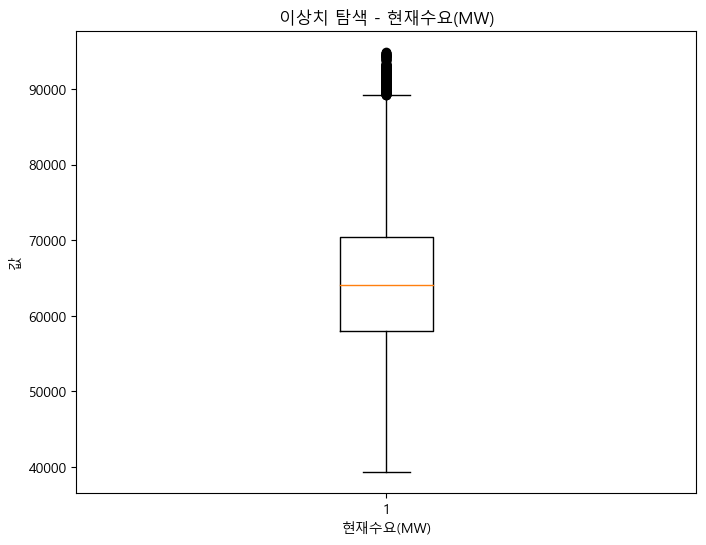

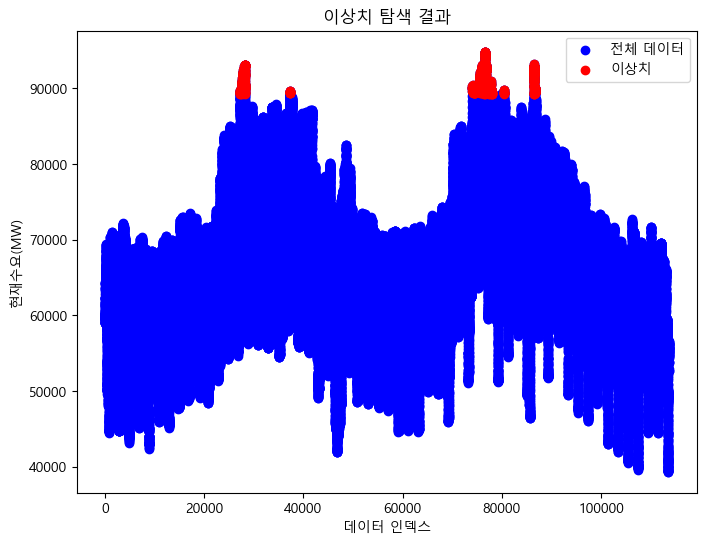

In [32]:
import pandas as pd

# 현재수요(MW) 칼럼의 이상치 탐색 함수
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    return outliers

# 현재수요(MW) 칼럼의 이상치 탐색
outliers = detect_outliers(df_ED, '현재수요(MW)')

# 이상치를 포함한 전체 데이터의 박스플롯 그리기
plt.figure(figsize=(8, 6))
plt.boxplot(df_ED['현재수요(MW)'])
plt.xlabel('현재수요(MW)')
plt.ylabel('값')
plt.title('이상치 탐색 - 현재수요(MW)')
plt.show()

# 이상치를 포함한 데이터의 산점도 그리기
plt.figure(figsize=(8, 6))
plt.scatter(df_ED.index, df_ED['현재수요(MW)'], color='b', label='전체 데이터')
plt.scatter(outliers.index, outliers['현재수요(MW)'], color='r', label='이상치')
plt.xlabel('데이터 인덱스')
plt.ylabel('현재수요(MW)')
plt.title('이상치 탐색 결과')
plt.legend()
plt.show()


In [33]:
# '현재수요(MW)' 열의 이상치 탐색
outliers = detect_outliers(df_ED, '현재수요(MW)')

# 이상치에 해당하는 행의 인덱스 추출
outlier_indices = outliers.index

print(outlier_indices)

Int64Index([27249, 27250, 27251, 27252, 27253, 27254, 27255, 27256, 27257,
            27260,
            ...
            86705, 86706, 86707, 86708, 86709, 86711, 86712, 86713, 86714,
            86715],
           dtype='int64', length=752)


In [34]:
len(outlier_indices)

752

In [35]:
df_ED.loc[86705:86715,:]

,현재수요(MW)
86705,89999.12
86706,89691.53
86707,89509.82
86708,89326.10
86709,89416.44
86710,89207.22
86711,89375.37
86712,89809.14
86713,89495.13
86714,89579.14


In [ ]:
# 이상치가 있는 열 추출
outlier_columns = []
for column in df_ED.columns[1:]:
    outliers = detect_outliers_iqr(df, column)
    if outliers is not None:
        outlier_columns.append(outliers)

In [ ]:
pd.DataFrame(outlier_columns)

In [ ]:
print(outlier_columns)

In [8]:
df_ED.columns[1:]

Index(['공급능력(MW)', '현재수요(MW)', '최대예측수요(MW)', '공급예비력(MW)', '공급예비율(퍼센트)',
       '운영예비력(MW)', '운영예비율(퍼센트)'],
      dtype='object')

In [9]:
list(df_ED.columns)

['기준일시',
 '공급능력(MW)',
 '현재수요(MW)',
 '최대예측수요(MW)',
 '공급예비력(MW)',
 '공급예비율(퍼센트)',
 '운영예비력(MW)',
 '운영예비율(퍼센트)']

In [10]:
# 예측해야한 기간(2023-03-13'~'2023-03-19') 탐색
df['기준일시'] = pd.to_datetime(df['기준일시'])
df.set_index('기준일시', inplace=True)
range_of_values = df.loc['2023-03-13':'2023-03-19']
pd.DataFrame(range_of_values)

NameError: name 'df' is not defined

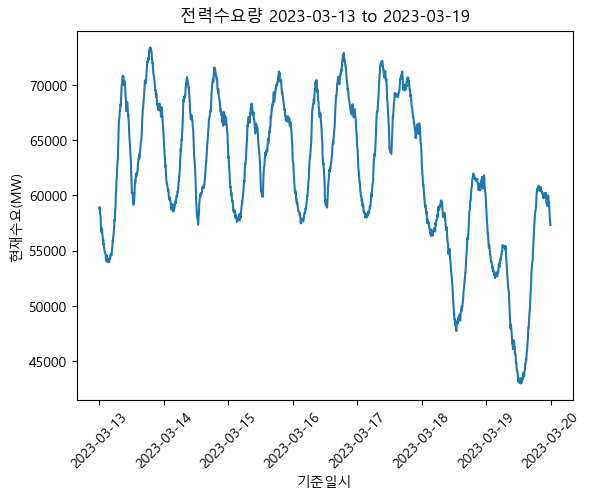

In [330]:
# 시각화
import matplotlib.pyplot as plt

# 한글폰트설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 예측해야할 그래프 모형
plt.plot(range_of_values.index, range_of_values['현재수요(MW)'])
plt.xlabel('기준일시')
plt.ylabel('현재수요(MW)')
plt.title('전력수요량 2023-03-13 to 2023-03-19')
plt.xticks(rotation=45)
plt.show()

In [295]:
df_c = df2 = pd.read_csv("추가자료.csv",encoding = 'cp949')
df_c

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2023-04-29 01:00,16.5,NaN,1.5,340,67,1008.2,NaN,NaN,NaN,10,15.3
1,90,속초,2023-04-29 02:00,16.9,NaN,0.9,320,65,1007.6,NaN,NaN,NaN,10,15.2
2,90,속초,2023-04-29 03:00,15.9,0.0,0.8,20,71,1007.0,NaN,NaN,NaN,10,15.1
3,90,속초,2023-04-29 04:00,14.4,0.3,2.0,360,82,1006.3,NaN,NaN,NaN,10,14.5
4,90,속초,2023-04-29 05:00,12.9,0.1,1.4,340,86,1006.2,NaN,NaN,NaN,10,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,295,남해,2023-04-30 20:00,16.0,NaN,0.5,290,47,1006.4,0.0,NaN,NaN,0,13.7
4557,295,남해,2023-04-30 21:00,15.4,NaN,0.6,250,47,1007.4,NaN,NaN,NaN,0,12.5
4558,295,남해,2023-04-30 22:00,12.8,NaN,0.5,290,61,1007.7,NaN,NaN,NaN,0,11.3
4559,295,남해,2023-04-30 23:00,14.3,NaN,0.3,0,50,1007.7,NaN,NaN,NaN,0,10.8


In [296]:
df_c['일시'] = pd.to_datetime(df_c['일시'])
df_c

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2023-04-29 01:00:00,16.5,NaN,1.5,340,67,1008.2,NaN,NaN,NaN,10,15.3
1,90,속초,2023-04-29 02:00:00,16.9,NaN,0.9,320,65,1007.6,NaN,NaN,NaN,10,15.2
2,90,속초,2023-04-29 03:00:00,15.9,0.0,0.8,20,71,1007.0,NaN,NaN,NaN,10,15.1
3,90,속초,2023-04-29 04:00:00,14.4,0.3,2.0,360,82,1006.3,NaN,NaN,NaN,10,14.5
4,90,속초,2023-04-29 05:00:00,12.9,0.1,1.4,340,86,1006.2,NaN,NaN,NaN,10,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,295,남해,2023-04-30 20:00:00,16.0,NaN,0.5,290,47,1006.4,0.0,NaN,NaN,0,13.7
4557,295,남해,2023-04-30 21:00:00,15.4,NaN,0.6,250,47,1007.4,NaN,NaN,NaN,0,12.5
4558,295,남해,2023-04-30 22:00:00,12.8,NaN,0.5,290,61,1007.7,NaN,NaN,NaN,0,11.3
4559,295,남해,2023-04-30 23:00:00,14.3,NaN,0.3,0,50,1007.7,NaN,NaN,NaN,0,10.8


In [297]:
# 특정 일자 범위 추출 
start_date = '2023-04-30'
end_date = '2023-05-01'
filtered_df = df_c[(df_c['일시'] >= start_date) & (df_c['일시'] <= end_date)]
filtered_df

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
23,90,속초,2023-04-30 00:00:00,12.8,NaN,2.3,290,57,1001.0,NaN,NaN,NaN,7,11.1
24,90,속초,2023-04-30 01:00:00,12.5,NaN,2.7,270,57,1000.7,NaN,NaN,NaN,6,10.9
25,90,속초,2023-04-30 02:00:00,12.4,NaN,1.4,270,53,1000.4,NaN,NaN,NaN,1,10.0
26,90,속초,2023-04-30 03:00:00,12.0,NaN,0.8,200,50,1000.4,NaN,NaN,NaN,0,9.2
27,90,속초,2023-04-30 04:00:00,12.5,NaN,3.3,270,43,1000.3,NaN,NaN,NaN,0,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,295,남해,2023-04-30 20:00:00,16.0,NaN,0.5,290,47,1006.4,0.0,NaN,NaN,0,13.7
4557,295,남해,2023-04-30 21:00:00,15.4,NaN,0.6,250,47,1007.4,NaN,NaN,NaN,0,12.5
4558,295,남해,2023-04-30 22:00:00,12.8,NaN,0.5,290,61,1007.7,NaN,NaN,NaN,0,11.3
4559,295,남해,2023-04-30 23:00:00,14.3,NaN,0.3,0,50,1007.7,NaN,NaN,NaN,0,10.8


In [298]:
df2 = pd.read_csv("기상변수.csv",encoding = 'cp949')
df2

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,90,속초,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,90,속초,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,90,속초,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,90,속초,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763881,295,남해,2023-04-29 20:00,15.0,NaN,2.9,290.0,74.0,1001.9,0.0,NaN,NaN,10.0,15.1
763882,295,남해,2023-04-29 21:00,13.7,NaN,3.4,290.0,71.0,1002.7,NaN,NaN,NaN,8.0,13.9
763883,295,남해,2023-04-29 22:00,12.6,NaN,3.5,290.0,70.0,1003.3,NaN,NaN,NaN,8.0,12.2
763884,295,남해,2023-04-29 23:00,11.8,NaN,1.4,250.0,71.0,1003.6,NaN,NaN,NaN,6.0,11.2


In [299]:
df3 = pd.read_csv("기상변수2.csv",encoding = 'cp949')
df3

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-04-01 00:00,3.8,NaN,1.3,270.0,84.0,1027.3,NaN,NaN,NaN,5.0,3.9
1,90,속초,2022-04-01 01:00,3.4,NaN,1.4,290.0,88.0,1027.7,NaN,NaN,NaN,4.0,3.1
2,90,속초,2022-04-01 02:00,2.8,NaN,1.7,290.0,86.0,1027.7,NaN,NaN,NaN,1.0,2.6
3,90,속초,2022-04-01 03:00,2.4,NaN,1.9,290.0,87.0,1027.7,NaN,NaN,NaN,0.0,2.3
4,90,속초,2022-04-01 04:00,2.9,NaN,1.1,320.0,84.0,1028.1,NaN,NaN,NaN,6.0,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134512,295,남해,2022-05-29 19:00,22.0,NaN,1.1,200.0,39.0,999.6,0.0,NaN,NaN,7.0,27.8
134513,295,남해,2022-05-29 20:00,21.7,NaN,0.5,180.0,33.0,999.7,0.0,NaN,NaN,5.0,25.2
134514,295,남해,2022-05-29 21:00,21.4,NaN,0.9,110.0,45.0,999.9,NaN,NaN,NaN,0.0,24.3
134515,295,남해,2022-05-29 22:00,21.1,NaN,1.4,180.0,52.0,1000.0,NaN,NaN,NaN,2.0,23.8


In [300]:
df4 = pd.concat([df2,df3,filtered_df])
df4

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,90,속초,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,90,속초,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,90,속초,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,90,속초,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4556,295,남해,2023-04-30 20:00:00,16.0,NaN,0.5,290.0,47.0,1006.4,0.0,NaN,NaN,0.0,13.7
4557,295,남해,2023-04-30 21:00:00,15.4,NaN,0.6,250.0,47.0,1007.4,NaN,NaN,NaN,0.0,12.5
4558,295,남해,2023-04-30 22:00:00,12.8,NaN,0.5,290.0,61.0,1007.7,NaN,NaN,NaN,0.0,11.3
4559,295,남해,2023-04-30 23:00:00,14.3,NaN,0.3,0.0,50.0,1007.7,NaN,NaN,NaN,0.0,10.8


In [301]:
df4 = df4.reset_index(drop=True)
df4

,지점,지점명,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,90,속초,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,90,속초,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,90,속초,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,90,속초,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,90,속초,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900774,295,남해,2023-04-30 20:00:00,16.0,NaN,0.5,290.0,47.0,1006.4,0.0,NaN,NaN,0.0,13.7
900775,295,남해,2023-04-30 21:00:00,15.4,NaN,0.6,250.0,47.0,1007.4,NaN,NaN,NaN,0.0,12.5
900776,295,남해,2023-04-30 22:00:00,12.8,NaN,0.5,290.0,61.0,1007.7,NaN,NaN,NaN,0.0,11.3
900777,295,남해,2023-04-30 23:00:00,14.3,NaN,0.3,0.0,50.0,1007.7,NaN,NaN,NaN,0.0,10.8


In [302]:
df4 = df4.drop(['지점','지점명'], axis=1)
df4

,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...
900774,2023-04-30 20:00:00,16.0,NaN,0.5,290.0,47.0,1006.4,0.0,NaN,NaN,0.0,13.7
900775,2023-04-30 21:00:00,15.4,NaN,0.6,250.0,47.0,1007.4,NaN,NaN,NaN,0.0,12.5
900776,2023-04-30 22:00:00,12.8,NaN,0.5,290.0,61.0,1007.7,NaN,NaN,NaN,0.0,11.3
900777,2023-04-30 23:00:00,14.3,NaN,0.3,0.0,50.0,1007.7,NaN,NaN,NaN,0.0,10.8


In [303]:
df4

,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
1,2022-05-30 01:00,16.7,NaN,1.3,320.0,82.0,1000.9,NaN,NaN,NaN,0.0,15.8
2,2022-05-30 02:00,16.8,NaN,0.3,0.0,78.0,1000.7,NaN,NaN,NaN,0.0,15.4
3,2022-05-30 03:00,18.5,NaN,3.4,360.0,73.0,1000.7,NaN,NaN,NaN,5.0,16.4
4,2022-05-30 04:00,17.6,NaN,2.9,360.0,86.0,1001.0,NaN,NaN,NaN,7.0,17.1
...,...,...,...,...,...,...,...,...,...,...,...,...
900774,2023-04-30 20:00:00,16.0,NaN,0.5,290.0,47.0,1006.4,0.0,NaN,NaN,0.0,13.7
900775,2023-04-30 21:00:00,15.4,NaN,0.6,250.0,47.0,1007.4,NaN,NaN,NaN,0.0,12.5
900776,2023-04-30 22:00:00,12.8,NaN,0.5,290.0,61.0,1007.7,NaN,NaN,NaN,0.0,11.3
900777,2023-04-30 23:00:00,14.3,NaN,0.3,0.0,50.0,1007.7,NaN,NaN,NaN,0.0,10.8


In [304]:
df4[df4['일시']=='2022-05-30 00:00']

,일시,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
0,2022-05-30 00:00,16.9,NaN,0.4,0.0,83.0,1001.2,NaN,NaN,NaN,0.0,16.1
8041,2022-05-30 00:00,17.3,NaN,0.0,0.0,83.0,992.8,NaN,NaN,NaN,0.0,16.8
16082,2022-05-30 00:00,17.3,NaN,0.8,140.0,100.0,986.4,NaN,NaN,NaN,0.0,16.5
24123,2022-05-30 00:00,17.7,NaN,0.0,0.0,91.0,990.5,NaN,NaN,NaN,2.0,17.2
32164,2022-05-30 00:00,16.5,NaN,0.3,0.0,98.0,1001.2,NaN,NaN,NaN,4.0,16.5
...,...,...,...,...,...,...,...,...,...,...,...,...
723681,2022-05-30 00:00,22.0,NaN,0.0,0.0,49.0,1000.8,NaN,NaN,NaN,4.0,24.5
731722,2022-05-30 00:00,22.6,0.0,0.2,0.0,39.0,1003.1,NaN,NaN,NaN,10.0,22.0
739763,2022-05-30 00:00,20.7,NaN,3.9,50.0,60.0,988.9,NaN,NaN,NaN,0.0,22.1
747804,2022-05-30 00:00,20.8,NaN,0.4,0.0,52.0,999.6,NaN,NaN,NaN,9.0,22.1


In [305]:
df4['일시'] = pd.to_datetime(df4['일시'])

In [306]:
# 일시별 나머지`b 열들의 평균값 계산
mean_df = df4.groupby('일시').mean()

In [307]:
mean_df

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
일시,,,,,,,,,,,
2022-04-01 00:00:00,6.180000,0.528571,1.849474,172.000000,81.884211,1015.023158,NaN,NaN,0.4,6.553191,6.186316
2022-04-01 01:00:00,5.684211,0.144444,1.745263,156.631579,83.148421,1015.344211,NaN,NaN,0.5,7.053191,5.702105
2022-04-01 02:00:00,5.257895,0.933333,1.561053,150.000000,84.505263,1015.386316,NaN,NaN,0.6,7.393617,5.307368
2022-04-01 03:00:00,4.855789,0.250000,1.535789,140.631579,85.042105,1015.292632,NaN,NaN,0.6,6.223404,4.801053
2022-04-01 04:00:00,4.486316,NaN,1.573684,138.526316,85.557895,1015.402105,NaN,NaN,0.6,5.106383,4.322105
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 20:00:00,14.831579,0.000000,2.283158,220.000000,54.315789,998.632632,0.002105,0.006667,NaN,2.378947,13.493684
2023-04-30 21:00:00,13.886316,0.025000,2.096842,213.263158,58.968421,999.383158,NaN,NaN,NaN,2.221053,12.431579
2023-04-30 22:00:00,13.172632,0.066667,2.020000,203.894737,61.873684,999.905263,NaN,NaN,0.1,2.536842,11.664211


In [308]:
# 5분 단위로 보간(interpolation)
df_interpolated = mean_df.resample('5T').interpolate()

In [309]:
df_interpolated 

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
일시,,,,,,,,,,,
2022-04-01 00:00:00,6.180000,0.528571,1.849474,172.000000,81.884211,1015.023158,NaN,NaN,0.400000,6.553191,6.186316
2022-04-01 00:05:00,6.138684,0.496561,1.840789,170.719298,81.989561,1015.049912,NaN,NaN,0.408333,6.594858,6.145965
2022-04-01 00:10:00,6.097368,0.464550,1.832105,169.438596,82.094912,1015.076667,NaN,NaN,0.416667,6.636525,6.105614
2022-04-01 00:15:00,6.056053,0.432540,1.823421,168.157895,82.200263,1015.103421,NaN,NaN,0.425000,6.678191,6.065263
2022-04-01 00:20:00,6.014737,0.400529,1.814737,166.877193,82.305614,1015.130175,NaN,NaN,0.433333,6.719858,6.024912
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:40:00,12.117961,0.426667,1.960885,196.940789,67.230117,1000.231477,0.002105,0.006667,0.100000,2.971637,10.809386
2023-04-30 23:45:00,12.073627,0.457500,1.976653,197.939967,67.474671,1000.264753,0.002105,0.006667,0.100000,2.989145,10.772664
2023-04-30 23:50:00,12.029293,0.488333,1.992421,198.939145,67.719225,1000.298030,0.002105,0.006667,0.100000,3.006652,10.735943


In [310]:
df_interpolated  = df_interpolated .drop(df_interpolated .index[-1])
df_interpolated

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
일시,,,,,,,,,,,
2022-04-01 00:00:00,6.180000,0.528571,1.849474,172.000000,81.884211,1015.023158,NaN,NaN,0.400000,6.553191,6.186316
2022-04-01 00:05:00,6.138684,0.496561,1.840789,170.719298,81.989561,1015.049912,NaN,NaN,0.408333,6.594858,6.145965
2022-04-01 00:10:00,6.097368,0.464550,1.832105,169.438596,82.094912,1015.076667,NaN,NaN,0.416667,6.636525,6.105614
2022-04-01 00:15:00,6.056053,0.432540,1.823421,168.157895,82.200263,1015.103421,NaN,NaN,0.425000,6.678191,6.065263
2022-04-01 00:20:00,6.014737,0.400529,1.814737,166.877193,82.305614,1015.130175,NaN,NaN,0.433333,6.719858,6.024912
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:35:00,12.162294,0.395833,1.945116,195.941612,66.985563,1000.198200,0.002105,0.006667,0.100000,2.954130,10.846107
2023-04-30 23:40:00,12.117961,0.426667,1.960885,196.940789,67.230117,1000.231477,0.002105,0.006667,0.100000,2.971637,10.809386
2023-04-30 23:45:00,12.073627,0.457500,1.976653,197.939967,67.474671,1000.264753,0.002105,0.006667,0.100000,2.989145,10.772664


In [311]:
df

,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
기준일시,,,,,,,
2022-04-01 00:00:00,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
2022-04-01 00:05:00,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2022-04-01 00:10:00,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
2022-04-01 00:15:00,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
2022-04-01 00:20:00,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...
2023-04-30 23:35:00,76101.03,53828.62,57300,22272.40,41.37651,9389.09,17.44257
2023-04-30 23:40:00,76084.24,53693.20,57300,22391.04,41.70181,8897.85,16.57166
2023-04-30 23:45:00,76083.32,52937.98,57300,23145.34,43.72161,9257.95,17.48829


In [312]:
df.loc['2022-04-01 00:00:00']

공급능력(MW)      82494.25000
현재수요(MW)      62453.29000
최대예측수요(MW)    70100.00000
공급예비력(MW)     20040.96000
공급예비율(퍼센트)       32.08951
운영예비력(MW)      9257.45000
운영예비율(퍼센트)       14.82300
Name: 2022-04-01 00:00:00, dtype: float64

In [313]:
# 인덱스 기준으로 교집합 데이터프레임 생성
intersection_df = pd.merge(df_interpolated, df, left_index=True, right_index=True)

# 결과 출력
intersection_df = pd.DataFrame(intersection_df)
intersection_df 

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C),공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
2022-04-01 00:00:00,6.180000,0.528571,1.849474,172.000000,81.884211,1015.023158,NaN,NaN,0.400000,6.553191,6.186316,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
2022-04-01 00:05:00,6.138684,0.496561,1.840789,170.719298,81.989561,1015.049912,NaN,NaN,0.408333,6.594858,6.145965,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2022-04-01 00:10:00,6.097368,0.464550,1.832105,169.438596,82.094912,1015.076667,NaN,NaN,0.416667,6.636525,6.105614,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
2022-04-01 00:15:00,6.056053,0.432540,1.823421,168.157895,82.200263,1015.103421,NaN,NaN,0.425000,6.678191,6.065263,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
2022-04-01 00:20:00,6.014737,0.400529,1.814737,166.877193,82.305614,1015.130175,NaN,NaN,0.433333,6.719858,6.024912,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:35:00,12.162294,0.395833,1.945116,195.941612,66.985563,1000.198200,0.002105,0.006667,0.100000,2.954130,10.846107,76101.03,53828.62,57300,22272.40,41.37651,9389.09,17.44257
2023-04-30 23:40:00,12.117961,0.426667,1.960885,196.940789,67.230117,1000.231477,0.002105,0.006667,0.100000,2.971637,10.809386,76084.24,53693.20,57300,22391.04,41.70181,8897.85,16.57166
2023-04-30 23:45:00,12.073627,0.457500,1.976653,197.939967,67.474671,1000.264753,0.002105,0.006667,0.100000,2.989145,10.772664,76083.32,52937.98,57300,23145.34,43.72161,9257.95,17.48829
2023-04-30 23:50:00,12.029293,0.488333,1.992421,198.939145,67.719225,1000.298030,0.002105,0.006667,0.100000,3.006652,10.735943,76077.47,52679.85,57300,23397.62,44.41474,9303.84,17.66110


In [314]:
list(different_values['Values'])
df_interpolated = df_interpolated.drop(list(different_values['Values']))
df_interpolated

,기온(°C),강수량(mm),풍속(m/s),풍향(16방위),습도(%),현지기압(hPa),일조(hr),일사(MJ/m2),적설(cm),전운량(10분위),지면온도(°C)
일시,,,,,,,,,,,
2022-04-01 00:00:00,6.180000,0.528571,1.849474,172.000000,81.884211,1015.023158,NaN,NaN,0.400000,6.553191,6.186316
2022-04-01 00:05:00,6.138684,0.496561,1.840789,170.719298,81.989561,1015.049912,NaN,NaN,0.408333,6.594858,6.145965
2022-04-01 00:10:00,6.097368,0.464550,1.832105,169.438596,82.094912,1015.076667,NaN,NaN,0.416667,6.636525,6.105614
2022-04-01 00:15:00,6.056053,0.432540,1.823421,168.157895,82.200263,1015.103421,NaN,NaN,0.425000,6.678191,6.065263
2022-04-01 00:20:00,6.014737,0.400529,1.814737,166.877193,82.305614,1015.130175,NaN,NaN,0.433333,6.719858,6.024912
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30 23:35:00,12.162294,0.395833,1.945116,195.941612,66.985563,1000.198200,0.002105,0.006667,0.100000,2.954130,10.846107
2023-04-30 23:40:00,12.117961,0.426667,1.960885,196.940789,67.230117,1000.231477,0.002105,0.006667,0.100000,2.971637,10.809386
2023-04-30 23:45:00,12.073627,0.457500,1.976653,197.939967,67.474671,1000.264753,0.002105,0.006667,0.100000,2.989145,10.772664


In [315]:
df_ff = df_interpolated[['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '지면온도(°C)']]
df_ff

,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),지면온도(°C)
일시,,,,,,
2022-04-01 00:00:00,6.180000,0.528571,1.849474,81.884211,NaN,6.186316
2022-04-01 00:05:00,6.138684,0.496561,1.840789,81.989561,NaN,6.145965
2022-04-01 00:10:00,6.097368,0.464550,1.832105,82.094912,NaN,6.105614
2022-04-01 00:15:00,6.056053,0.432540,1.823421,82.200263,NaN,6.065263
2022-04-01 00:20:00,6.014737,0.400529,1.814737,82.305614,NaN,6.024912
...,...,...,...,...,...,...
2023-04-30 23:35:00,12.162294,0.395833,1.945116,66.985563,0.002105,10.846107
2023-04-30 23:40:00,12.117961,0.426667,1.960885,67.230117,0.002105,10.809386
2023-04-30 23:45:00,12.073627,0.457500,1.976653,67.474671,0.002105,10.772664


In [316]:
df_fff = pd.DataFrame(df['현재수요(MW)'])
df_fff

,현재수요(MW)
기준일시,
2022-04-01 00:00:00,62453.29
2022-04-01 00:05:00,62329.25
2022-04-01 00:10:00,61830.96
2022-04-01 00:15:00,61648.72
2022-04-01 00:20:00,61382.62
...,...
2023-04-30 23:35:00,53828.62
2023-04-30 23:40:00,53693.20
2023-04-30 23:45:00,52937.98


In [317]:
df= df.drop(list(different_values['Values']), errors='ignore')
df

,공급능력(MW),현재수요(MW),최대예측수요(MW),공급예비력(MW),공급예비율(퍼센트),운영예비력(MW),운영예비율(퍼센트)
기준일시,,,,,,,
2022-04-01 00:00:00,82494.25,62453.29,70100,20040.96,32.08951,9257.45,14.82300
2022-04-01 00:05:00,83807.25,62329.25,70700,21477.99,34.45893,10889.28,17.47058
2022-04-01 00:10:00,83799.12,61830.96,70700,21968.15,35.52937,10865.86,17.57350
2022-04-01 00:15:00,83790.42,61648.72,70700,22141.69,35.91589,10864.26,17.62284
2022-04-01 00:20:00,83770.82,61382.62,70700,22388.19,36.47318,10451.95,17.02754
...,...,...,...,...,...,...,...
2023-04-30 23:35:00,76101.03,53828.62,57300,22272.40,41.37651,9389.09,17.44257
2023-04-30 23:40:00,76084.24,53693.20,57300,22391.04,41.70181,8897.85,16.57166
2023-04-30 23:45:00,76083.32,52937.98,57300,23145.34,43.72161,9257.95,17.48829


In [318]:
df_ffff = pd.concat([df_ff,df_fff],axis=1)
df_ffff

,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),지면온도(°C),현재수요(MW)
2022-04-01 00:00:00,6.180000,0.528571,1.849474,81.884211,NaN,6.186316,62453.29
2022-04-01 00:05:00,6.138684,0.496561,1.840789,81.989561,NaN,6.145965,62329.25
2022-04-01 00:10:00,6.097368,0.464550,1.832105,82.094912,NaN,6.105614,61830.96
2022-04-01 00:15:00,6.056053,0.432540,1.823421,82.200263,NaN,6.065263,61648.72
2022-04-01 00:20:00,6.014737,0.400529,1.814737,82.305614,NaN,6.024912,61382.62
...,...,...,...,...,...,...,...
2023-04-30 23:35:00,12.162294,0.395833,1.945116,66.985563,0.002105,10.846107,53828.62
2023-04-30 23:40:00,12.117961,0.426667,1.960885,67.230117,0.002105,10.809386,53693.20
2023-04-30 23:45:00,12.073627,0.457500,1.976653,67.474671,0.002105,10.772664,52937.98
2023-04-30 23:50:00,12.029293,0.488333,1.992421,67.719225,0.002105,10.735943,52679.85


In [319]:
df_ffff = df_ffff.fillna(0)
df_ffff

,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),지면온도(°C),현재수요(MW)
2022-04-01 00:00:00,6.180000,0.528571,1.849474,81.884211,0.000000,6.186316,62453.29
2022-04-01 00:05:00,6.138684,0.496561,1.840789,81.989561,0.000000,6.145965,62329.25
2022-04-01 00:10:00,6.097368,0.464550,1.832105,82.094912,0.000000,6.105614,61830.96
2022-04-01 00:15:00,6.056053,0.432540,1.823421,82.200263,0.000000,6.065263,61648.72
2022-04-01 00:20:00,6.014737,0.400529,1.814737,82.305614,0.000000,6.024912,61382.62
...,...,...,...,...,...,...,...
2023-04-30 23:35:00,12.162294,0.395833,1.945116,66.985563,0.002105,10.846107,53828.62
2023-04-30 23:40:00,12.117961,0.426667,1.960885,67.230117,0.002105,10.809386,53693.20
2023-04-30 23:45:00,12.073627,0.457500,1.976653,67.474671,0.002105,10.772664,52937.98
2023-04-30 23:50:00,12.029293,0.488333,1.992421,67.719225,0.002105,10.735943,52679.85


Mean Absolute Percentage Error (MAPE): 0.10089206548493479


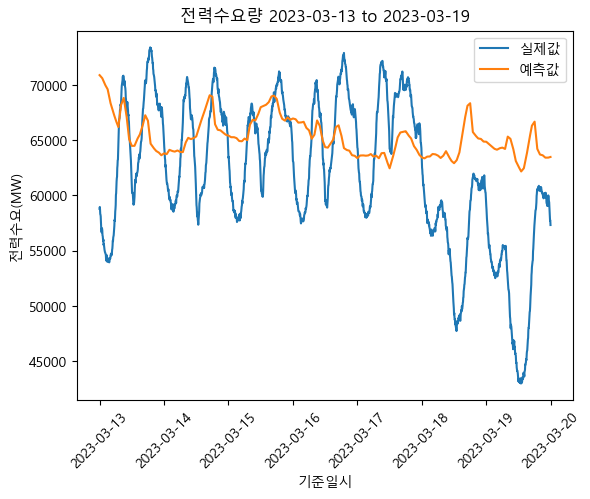

In [320]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 필요한 가상정보와 전력수요 사이의 상관관계를 고려하여 입력 변수(X)와 출력 변수(y)로 분할
X = df_ffff[['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '지면온도(°C)']]
y = df_ffff['현재수요(MW)']

# 회귀분석 모델 학습
reg_model = LinearRegression()
reg_model.fit(X, y)

# 특정 기간의 데이터만 선택
start_date = '2023-03-13'
end_date = '2023-03-19'
filtered_X = X.loc[start_date:end_date]
filtered_y = y.loc[start_date:end_date]

# 테스트 데이터에 대한 예측
y_pred = reg_model.predict(filtered_X)

# MAPE 계산
mape = mean_absolute_percentage_error(filtered_y, y_pred)

# 결과 출력
print("Mean Absolute Percentage Error (MAPE):", mape)

# 그래프로 실제값과 예측값 나타내기
plt.plot(filtered_y.index, filtered_y, label='실제값')
plt.plot(filtered_y.index, y_pred, label='예측값')
plt.xlabel('기준일시')
plt.ylabel('전력수요(MW)')
plt.title('전력수요량 {} to {}'.format(start_date, end_date))
plt.xticks(rotation=45)
plt.legend()
plt.show()


# 회귀분석

Mean Absolute Percentage Error (MAPE): 0.11079588960093842


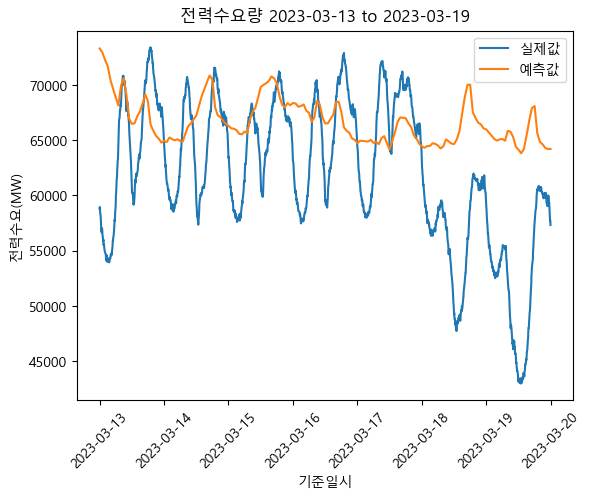

In [321]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 필요한 가상정보와 전력수요 사이의 상관관계를 고려하여 입력 변수(X)와 출력 변수(y)로 분할
X = df_ffff[['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '지면온도(°C)']]
y = df_ffff['현재수요(MW)']

# 특정 기간 필터링
start_date = '2022-04-01'
end_date = '2023-03-12'
filtered_X = X[(X.index >= start_date) & (X.index <= end_date)]
filtered_y = y[(y.index >= start_date) & (y.index <= end_date)]

# 회귀분석 모델 학습
reg_model = LinearRegression()
reg_model.fit(filtered_X, filtered_y)

# 특정 기간의 데이터만 선택
start_date = '2023-03-13'
end_date = '2023-03-19'
filtered_X = X.loc[start_date:end_date]
filtered_y = y.loc[start_date:end_date]

# 테스트 데이터에 대한 예측
y_pred = reg_model.predict(filtered_X)

# MAPE 계산
mape = mean_absolute_percentage_error(filtered_y, y_pred)

# 결과 출력
print("Mean Absolute Percentage Error (MAPE):", mape)

# 그래프로 실제값과 예측값 나타내기
plt.plot(filtered_y.index, filtered_y, label='실제값')
plt.plot(filtered_y.index, y_pred, label='예측값')
plt.xlabel('기준일시')
plt.ylabel('전력수요(MW)')
plt.title('전력수요량 {} to {}'.format(start_date, end_date))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 랜덤포레스트

Mean Absolute Percentage Error (MAPE): 0.11282511909255995


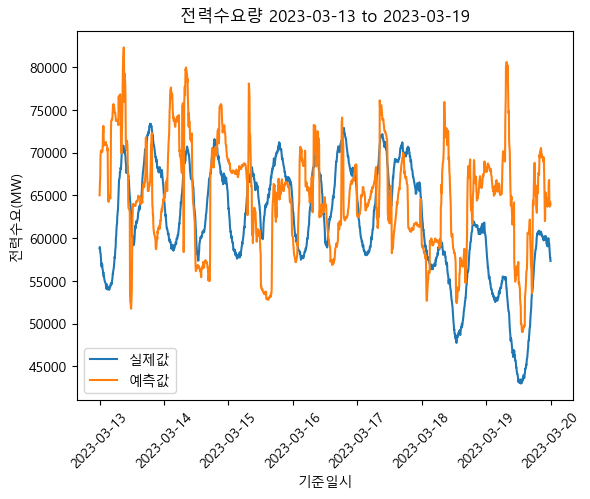

In [322]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# 필요한 가상정보와 전력수요 사이의 상관관계를 고려하여 입력 변수(X)와 출력 변수(y)로 분할
X = df_ffff[['기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '지면온도(°C)']]
y = df_ffff['현재수요(MW)']

# 특정 기간 필터링
start_date = '2022-04-01'
end_date = '2023-03-12'
filtered_X = X[(X.index >= start_date) & (X.index <= end_date)]
filtered_y = y[(y.index >= start_date) & (y.index <= end_date)]

# 모델 선택 및 학습
model = RandomForestRegressor()
model.fit(filtered_X, filtered_y)

# 특정 기간의 데이터만 선택
start_date = '2023-03-13'
end_date = '2023-03-19'
filtered_X = X.loc[start_date:end_date]
filtered_y = y.loc[start_date:end_date]

# 테스트 데이터에 대한 예측
y_pred = model.predict(filtered_X)

# MAPE 계산
mape = mean_absolute_percentage_error(filtered_y, y_pred)

# 결과 출력
print("Mean Absolute Percentage Error (MAPE):", mape)

# 그래프로 실제값과 예측값 나타내기
plt.plot(filtered_y.index, filtered_y, label='실제값')
plt.plot(filtered_y.index, y_pred, label='예측값')
plt.xlabel('기준일시')
plt.ylabel('전력수요(MW)')
plt.title('전력수요량 {} to {}'.format(start_date, end_date))
plt.xticks(rotation=45)
plt.legend()
plt.show()
